# Stone Classification Advanced
## Train the Model

In [1]:
import os, math, time, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR
from safetensors.torch import load_file
import torchvision.transforms as T

from dataset import StoneDatasetCached       # ← 上一步实现的缓存版 Dataset
from model_efficient import EfficientV2S_MTL # 继承后复用

# ---------- 超参 ----------
ROOT        = "./dataset"
CKPT_PATH   = "./model.safetensors"          # TF EfficientNetV2‑S (in21k) 权重
BATCH       = 64
EPOCHS      = 10
WARMUP_E    = 2
LR_BASE     = 5e-4
WD          = 1e-3
ALPHA_MIX   = 0.2                            # β 分布参数
EARLY_STOP  = 5
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
# -----------Transforms-------------
# tfm = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4602, 0.4554, 0.4505), (0.2840, 0.2832, 0.2888))
# ])

# # ds_train = StoneDataset(root, split="train", transforms=tfm)
# # ds_val   = StoneDataset(root, split="val",   transforms=tfm)
# aug_train = transforms.Compose([
#     transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),   # 最短边 256
#     transforms.RandomCrop(224),        # 保留随机视野，增鲁棒
#     # transforms.RandAugment(num_ops=2, magnitude=9),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.2)], p=0.5),
#     transforms.RandomGrayscale(p=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4602, 0.4554, 0.4505), (0.2840, 0.2832, 0.2888))
# ])

extra_aug_train = T.Compose([
    T.RandomApply([T.ColorJitter(0.4,0.4,0.4,0.2)], p=0.5),
    T.RandomGrayscale(p=0.1),
])

# 对验证/测试通常不再做颜色扰动
extra_aug_eval = None

ds_train = StoneDatasetCached(ROOT, "train", transforms=extra_aug_train)
ds_val   = StoneDatasetCached(ROOT, "val",   transforms=extra_aug_eval)

In [2]:
# -----------------------------------------------------------
# build mapping matrix  W [N_fine, 3]  (one-hot per fine class)
N_FINE = len(ds_train.fine2idx)
W = torch.zeros(N_FINE, 3)            # CPU tensor
for fine_name, fid in ds_train.fine2idx.items():
    cid = ds_train.fine2coarse[fine_name]   # 0/1/2
    W[fid, cid] = 1.0
W = W.to(DEVICE)          # later we'll @ to project logits_fine → coarse space
# -----------------------------------------------------------

In [3]:
# -------- 长尾采样（可选） --------
# fine_counts = np.bincount([f for _,f,_ in ds_train.samples])
# weights = 1. / fine_counts
# sampler = WeightedRandomSampler([weights[f] for _,f,_ in ds_train.samples],
#                                 num_samples=len(ds_train), replacement=True)
base_w = np.bincount([f for _,f,_ in ds_train.samples], minlength=N_FINE)
class_w = 1. / base_w
sample_w = []
for (_, f, _), q in zip(ds_train.samples, ds_train.qweights):
    sample_w.append(class_w[f] * q)      # 低质量图 ×0.2
sampler = WeightedRandomSampler(sample_w, len(sample_w), replacement=True)

dl_train = DataLoader(ds_train, BATCH, sampler=sampler, num_workers=4,          # 根据 CPU 核心数调整
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True)
dl_val   = DataLoader(ds_val,   BATCH, shuffle=False, num_workers=4)

In [4]:
# -------- Load Model --------
model = EfficientV2S_MTL(n_fine=len(ds_train.fine2idx)).to(DEVICE)

opt = torch.optim.AdamW(model.parameters(), lr=LR_BASE, weight_decay=WD)

def lr_lambda(step):
    epoch = step / len(dl_train)
    if epoch < WARMUP_E:
        return epoch / WARMUP_E
    progress = (epoch - WARMUP_E) / (EPOCHS - WARMUP_E)
    return max(1e-6, 0.5 * (1 + math.cos(math.pi * progress)))

scheduler = LambdaLR(opt, lr_lambda, -1)
scaler = GradScaler()
torch.backends.cudnn.benchmark = True

ce_fine   = nn.CrossEntropyLoss(label_smoothing=0.05)
ce_coarse = nn.CrossEntropyLoss()

In [5]:
# ---------- 记录 ----------
best_loss, stall = 1e9, 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# ---------- 训练循环 ----------
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train(); tloss=0; tcorrect=0; tsamp=0
    for imgs, fine_id, coarse_id, _ in dl_train:
        imgs, fine_id, coarse_id = (imgs.to(DEVICE, non_blocking=True),
                                    fine_id.to(DEVICE, non_blocking=True),
                                    coarse_id.to(DEVICE, non_blocking=True))
        # ---- MixUp ----
        if np.random.rand() < 0.8:
            lam = np.random.beta(ALPHA_MIX, ALPHA_MIX)
            perm = torch.randperm(imgs.size(0), device=DEVICE)
            imgs = lam * imgs + (1 - lam) * imgs[perm]
            target = lam * F.one_hot(coarse_id, 3) + (1 - lam) * F.one_hot(coarse_id[perm], 3)
        else:
            target = F.one_hot(coarse_id, 3).float()

        with autocast(device_type='cuda'):
            # out_fine, out_coarse = model(imgs)
            # loss_mix = -(target * F.log_softmax(out_coarse,1)).sum(1).mean()
            # loss = 0.3*ce_fine(out_fine, fine_id) + 0.7*loss_mix
            logits_fine, logits_coarse = model(imgs)

            # --- (1) 细粒度交叉熵 ---
            loss_fine = ce_fine(logits_fine, fine_id)
        
            # --- (2) 粗粒度 MixUp 交叉熵 (保持原逻辑) ---
            loss_mix = -(target * F.log_softmax(logits_coarse, 1)).sum(1).mean()
        
            # --- (3) 层级一致性：把细 logits 投到 coarse 空间 ---
            #   logits_f2c shape [B, 3] = logits_fine @ W
            logits_f2c = logits_fine @ W        # no param, very cheap
            prob_f2c   = F.softmax(logits_f2c, 1)
            prob_coarse_det = F.softmax(logits_coarse.detach(), 1)
            loss_hier  = F.mse_loss(prob_f2c, prob_coarse_det)
        
            # --- 总损失 ---
            loss = 0.25 * loss_fine + 0.55 * loss_mix + 0.2 * loss_hier

        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        scheduler.step()

        tloss += loss.item()*imgs.size(0)
        tcorrect += (logits_coarse.argmax(1)==coarse_id).sum().item()
        tsamp += imgs.size(0)

    # ---- 验证 ----
    model.eval(); vloss=0; vcorrect=0; vsamp=0
    with torch.no_grad(), autocast(device_type='cuda'):
        for imgs, _, coarse_id in dl_val:
            imgs, coarse_id = imgs.to(DEVICE,non_blocking=True), coarse_id.to(DEVICE,non_blocking=True)
            _, out = model(imgs)
            loss = ce_coarse(out, coarse_id)
            vloss += loss.item()*imgs.size(0)
            vcorrect += (out.argmax(1)==coarse_id).sum().item()
            vsamp += imgs.size(0)

    avg_tloss, avg_vloss = tloss/tsamp, vloss/vsamp
    tacc, vacc = tcorrect/tsamp, vcorrect/vsamp
    
    train_losses.append(avg_tloss)
    val_losses.append(avg_vloss)
    train_accuracies.append(tacc)
    val_accuracies.append(vacc)

    print(f"[Ep {epoch:02d}] {(time.time()-t0):.1f}s "
          f"| TL {avg_tloss:.3f} TA {tacc:.3f} "
          f"| VL {avg_vloss:.3f} VA {vacc:.3f}")

    # # ---- Early‑Stopping ----
    # if avg_vloss < best_loss:
    #     best_loss = avg_vloss; stall = 0
    #     torch.save(model.state_dict(), "best_mtl.pt")
    # else:
    #     stall += 1
    #     if stall >= EARLY_STOP:
    #         print("Early stopping!")
    #         break

[Ep 01] 289.7s | TL 1.864 TA 0.570 | VL 0.817 VA 0.656
[Ep 02] 279.5s | TL 1.585 TA 0.632 | VL 0.818 VA 0.661
[Ep 03] 276.9s | TL 1.481 TA 0.656 | VL 0.833 VA 0.673
[Ep 04] 277.3s | TL 1.358 TA 0.693 | VL 0.857 VA 0.681
[Ep 05] 279.2s | TL 1.282 TA 0.703 | VL 0.793 VA 0.691
[Ep 06] 277.0s | TL 1.216 TA 0.719 | VL 0.828 VA 0.695
[Ep 07] 275.3s | TL 1.187 TA 0.710 | VL 0.787 VA 0.709
[Ep 08] 277.3s | TL 1.117 TA 0.727 | VL 0.802 VA 0.710
[Ep 09] 274.8s | TL 1.094 TA 0.726 | VL 0.779 VA 0.711
[Ep 10] 269.9s | TL 1.037 TA 0.748 | VL 0.822 VA 0.717


## Save Good Model

In [6]:
checkpoint_path = "./efficient_v2_s_in21M_hier_multi.pth"
# 保存 checkpoint
torch.save({
    'epoch': EPOCHS,
    'model_state': model.state_dict(),
    "fine2idx"   : ds_train.fine2idx,
    'optimizer_state': opt.state_dict(),
    'scheduler_state': scheduler.state_dict(),
    'train_losses': tloss,
    'val_losses': vloss,
    'train_accuracies': tacc,
    'val_accuracies': vacc
}, checkpoint_path)

## Plot the results

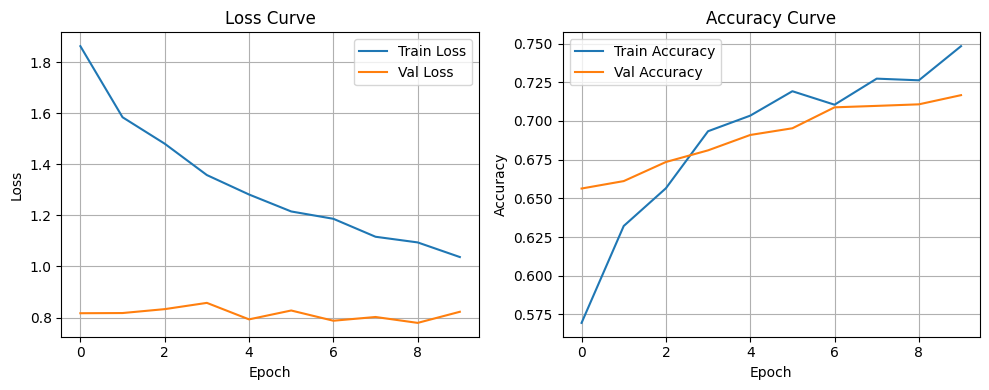

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Final Model Load and test

In [11]:
import torch, pandas as pd
from torch.utils.data import DataLoader
from torch.amp import autocast
from dataset import StoneDatasetCached          # ← 你现有的 dataset
from model_efficient import EfficientV2S_MTL    # ← 定义与训练时一致

# ---------- 路径 ----------
ROOT        = "./dataset"
CKPT        = "./efficient_v2_s_in21M_fine_hier_multi.pth"       # or your_model.pth
SUB_CSV     = f"{ROOT}/test/sample_submission.csv"
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- Data ----------
state = torch.load(CKPT, map_location="cpu", weights_only=True)

ds_test = StoneDatasetCached(ROOT, "test")        # __getitem__ 返回 (tensor, fname)
ds_test.fine2idx = state["fine2idx"]
# ds_test.fine2idx = ds_train.fine2idx
dl_test = DataLoader(ds_test, batch_size=64, shuffle=False,
                     num_workers=4, pin_memory=True)


# ---------- Model ----------
fresh = EfficientV2S_MTL(n_fine=len(ds_test.fine2idx)).to(DEVICE)
state  = state['model_state'] if 'model_state' in state else state
fresh.load_state_dict(state, strict=False)
fresh.eval()

# ---------- Inference ----------
# preds = {};  # fname → coarse_id
# vcorrect=0;                        
# with torch.no_grad(), autocast(device_type='cuda'):
#     for imgs, fnames, coarse_id in dl_test:
#         imgs, coarse_id = imgs.to(DEVICE,non_blocking=True), coarse_id.to(DEVICE,non_blocking=True)
#         _, logits_coarse = fresh(imgs)          # 只要 coarse 头
#         vcorrect += (logits_coarse.argmax(1)==coarse_id).sum().item()
#         pred = logits_coarse.argmax(1).cpu().tolist()
#         preds.update(dict(zip(fnames, pred)))

preds = {};  # fname → coarse_id
with torch.no_grad(), autocast(device_type='cuda'):
    for imgs, fnames in dl_test:
        imgs = imgs.to(DEVICE,non_blocking=True)
        _, logits_coarse = fresh(imgs)          # 只要 coarse 头
        pred = logits_coarse.argmax(1).cpu().tolist()
        preds.update(dict(zip(fnames, pred)))

# ---------- 写回 CSV ----------
sub = pd.read_csv(SUB_CSV)          # 假定第一列 id, 第二列 label
sub.iloc[:, 1] = sub["id"].map(preds) 
sub.to_csv(SUB_CSV, index=False)
print(f"✅  Saved predictions to {SUB_CSV}")


✅  Saved predictions to ./dataset/test/sample_submission.csv
